In [134]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.append("../../scripts")
import importlib

import model
importlib.reload(model)
from model import Model, model_from_file

import model_plot
importlib.reload(model_plot)
from model_plot import model_plot

%matplotlib inline

In [135]:
models_dir = '../../bin/'

In [136]:
model = model_from_file(models_dir + 'model.csv')

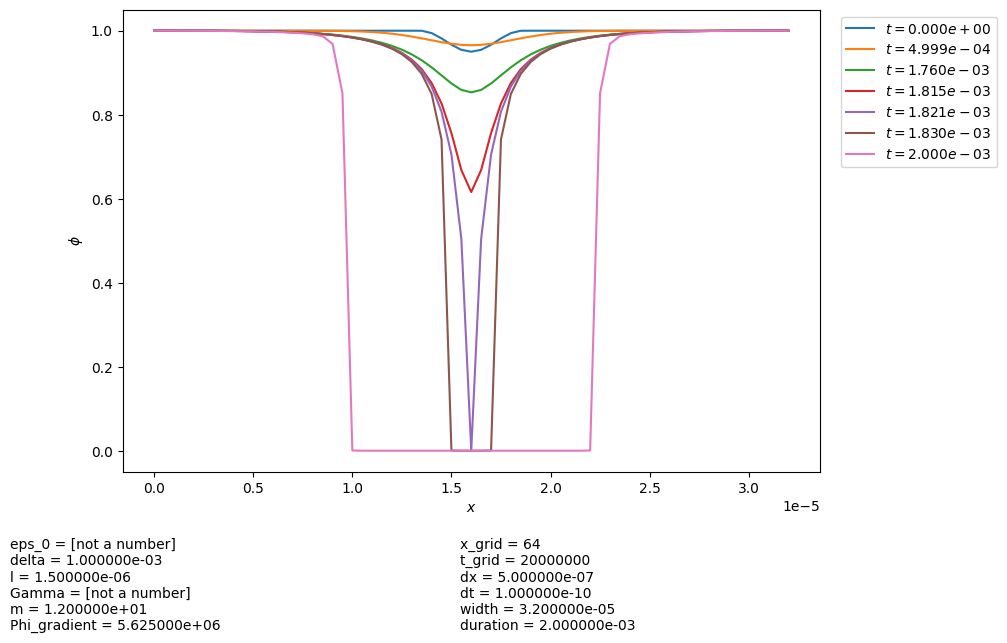

In [137]:
ts = [0, 5e-4, 1.76e-3, 1.815e-3, 1.821e-3, 1.83e-3, 2e-3]
model_plot(model, ts, figsize=(9, 6))

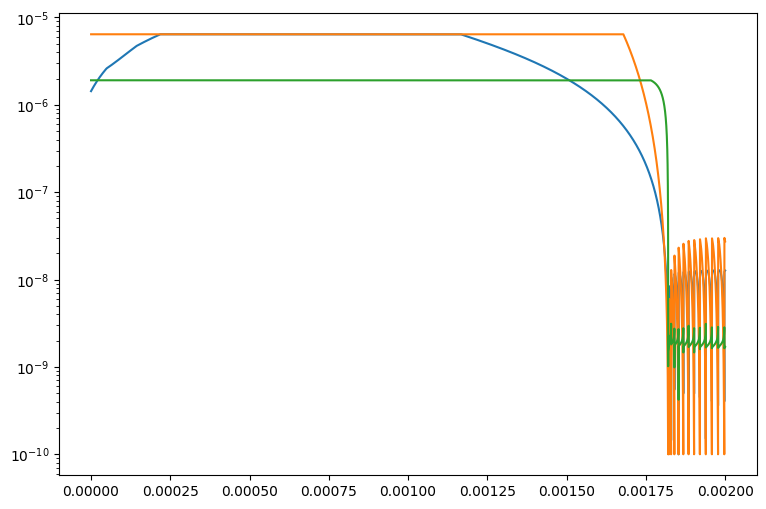

In [138]:
plt.figure(figsize=(9, 6))
plt.yscale('log')
plt.plot(model.ts, model._dt_adaptive_phi)
plt.plot(model.ts[1:], model._dt_adaptive_energy[1:])
plt.plot(model.ts, model._dt_adaptive_stability)
plt.show()

In [139]:
model_ad_phi = model_from_file(models_dir + 'model_ad_phi.csv')

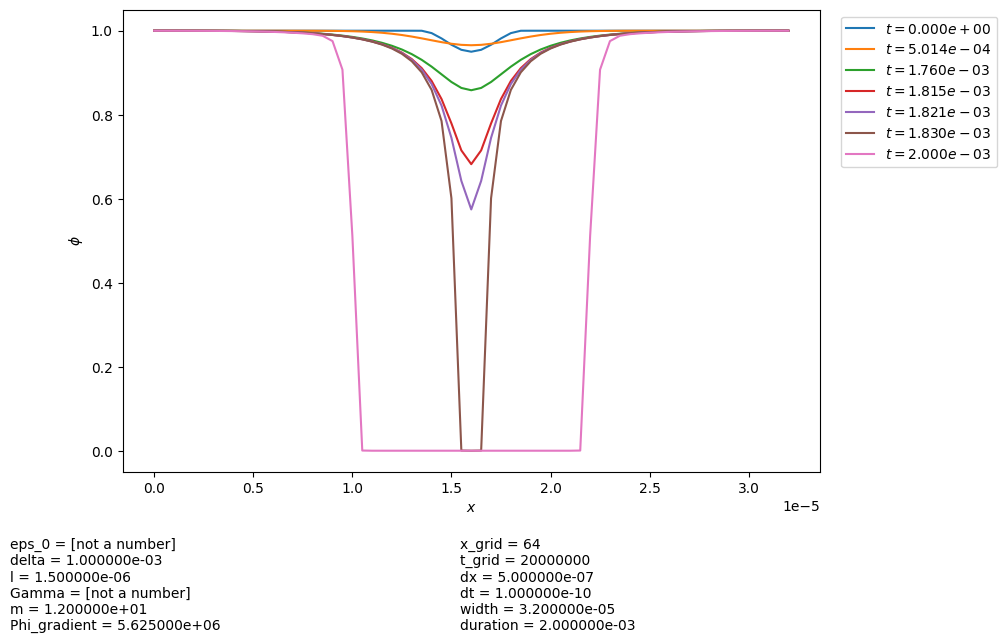

In [140]:
model_plot(model_ad_phi, ts, figsize=(9, 6))

In [141]:
model_ad_energy = model_from_file(models_dir + 'model_ad_energy.csv')

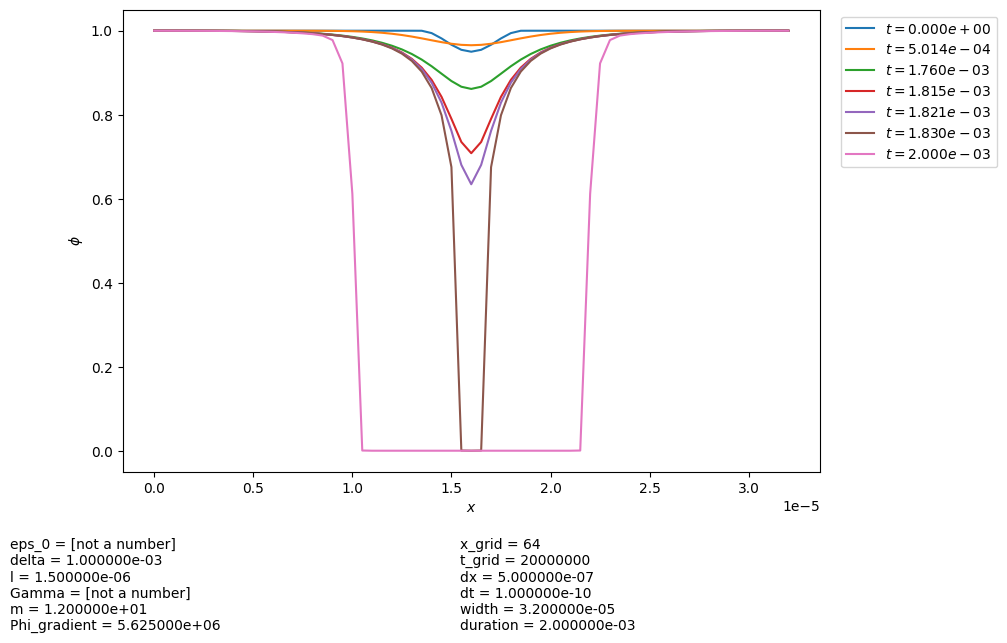

In [142]:
model_plot(model_ad_energy, ts, figsize=(9, 6))

In [143]:
model_ad_stability = model_from_file(models_dir + 'model_ad_stability.csv')

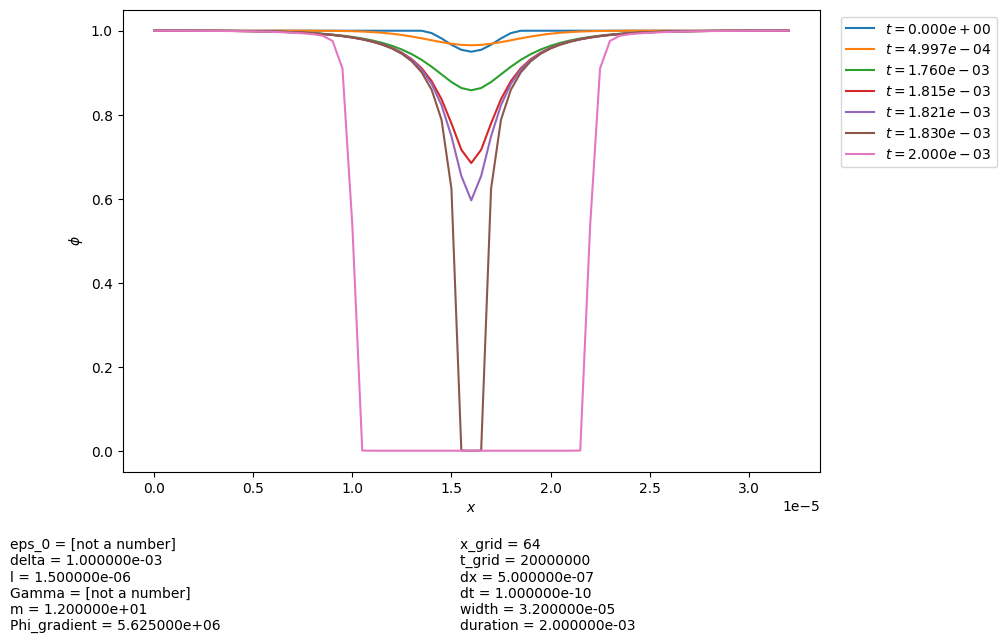

In [144]:
model_plot(model_ad_stability, ts, figsize=(9, 6))

In [145]:
def boost(model_adaptive):
    print('Шагов было:', model._t_iterations.sum())
    print('Шагов стало:', model_adaptive._t_iterations.sum() - 1)
    print('Ускорение ~', model._t_iterations.sum() / (model_adaptive._t_iterations.sum() - 1))

In [146]:
boost(model_ad_phi)

Шагов было: 19998721
Шагов стало: 62031
Ускорение ~ 322.3988167206719


In [147]:
boost(model_ad_energy)

Шагов было: 19998721
Шагов стало: 186839
Ускорение ~ 107.03718709691232


In [148]:
boost(model_ad_stability)

Шагов было: 19998721
Шагов стало: 112369
Ускорение ~ 177.97364931609252


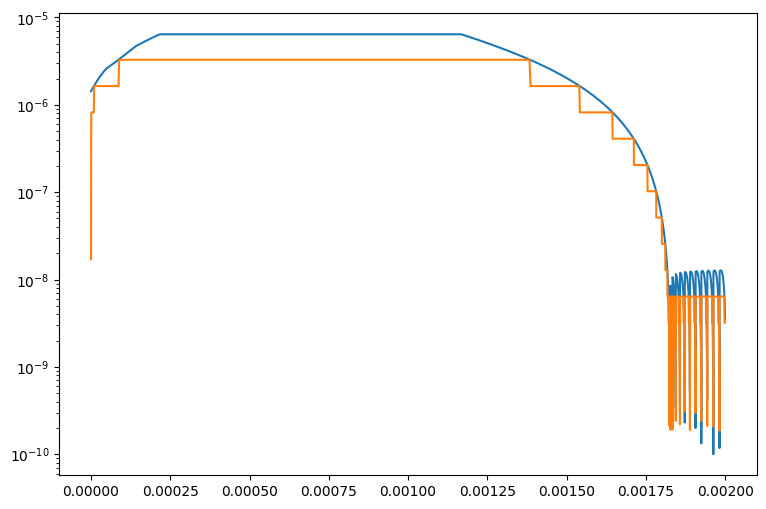

In [149]:
plt.figure(figsize=(9, 6))
plt.yscale('log')
plt.plot(model_ad_phi.ts, model_ad_phi._dt_adaptive_phi)
plt.plot(model_ad_phi.ts[:-1], (model_ad_phi.ts[1:] - model_ad_phi.ts[:-1]) / model_ad_phi._t_iterations[1:])
plt.show()

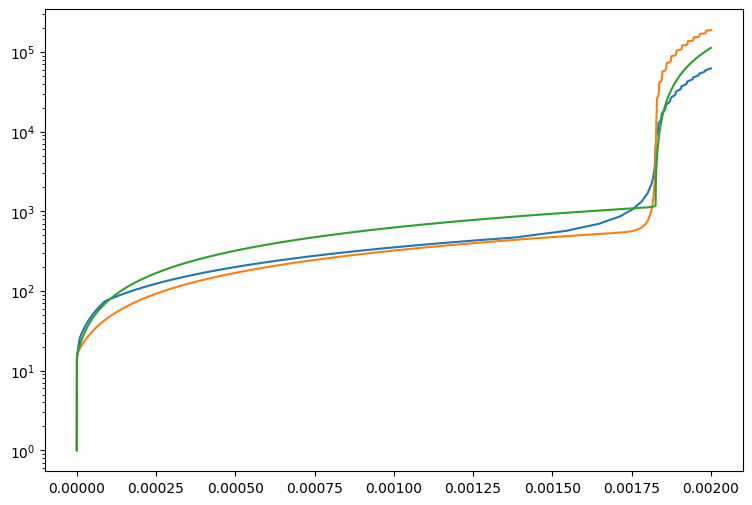

In [152]:
plt.figure(figsize=(9, 6))
plt.yscale('log')
plt.plot(model_ad_phi.ts, model_ad_phi._t_iterations.cumsum())
plt.plot(model_ad_energy.ts, model_ad_energy._t_iterations.cumsum())
plt.plot(model_ad_stability.ts, model_ad_stability._t_iterations.cumsum())
plt.show()